# Training a Jet Tagging with **Recurrent Neural Network** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier with a GRU unit.
Gated Recurrent Units are one kind of RNNs. 

The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [ ]:
! git clone https://github.com/pierinim/tutorials.git

In [3]:
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [33]:
target = np.array([])
jetList = np.array([])
p_featurenames = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetList = np.concatenate([jetList, myJetList], axis=0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
    
# normalize features in [0,1] range
#from sklearn.preprocessing import MinMaxScaler
scaled_jetList = np.array([])
for i in range(jetList.shape[-1]):
#    scaler = MinMaxScaler(feature_range=(0, 1))
#    my_data = scaler.fit_transform(jetList[:,:,i])
    my_data = jetList[:,:,i]
    my_data = (my_data - my_data.min())/(my_data.max()-my_data.min())
    my_data = np.reshape(my_data, (my_data.shape[0], my_data.shape[1], 1))
    scaled_jetList = np.concatenate([scaled_jetList, my_data], axis=-1) if scaled_jetList.size else my_data
jetList = scaled_jetList

print(target.shape, jetList.shape)
f = h5py.File(datafiles[0])
p_featurenames = np.array(f.get("particleFeatureNames"))
print(p_featurenames[:])

Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)
[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


# Plot particle features

The dataset consists of 50000 with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

In [34]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot_p(X, Y, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        my_data = X[:,:]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(Y, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonposy='clip')    
    plt.legend(labelCat, fontsize=12, frameon=False)  
    plt.xlabel(str(input_featurenames, "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

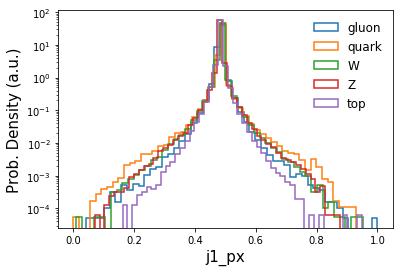

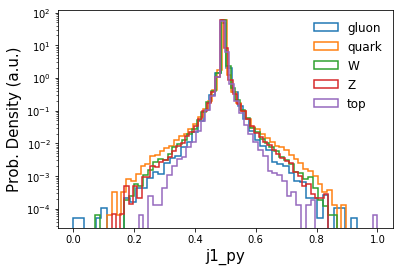

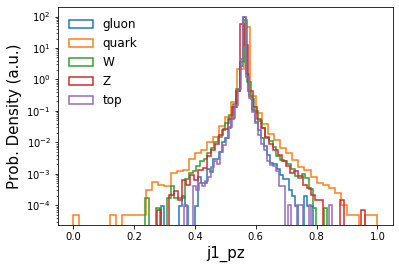

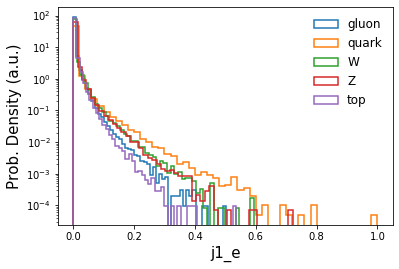

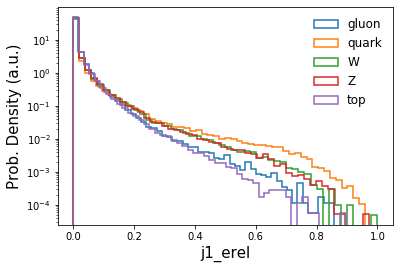

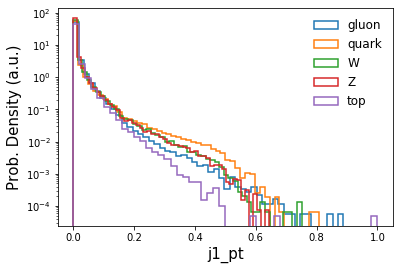

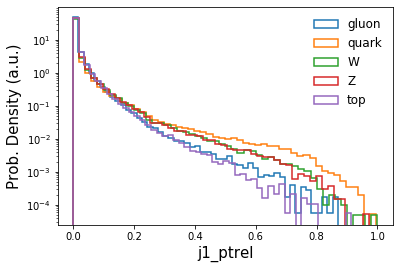

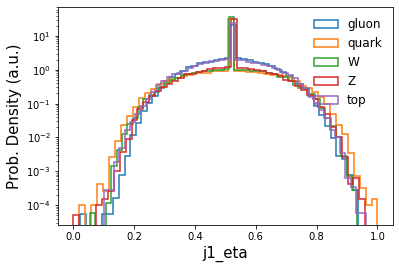

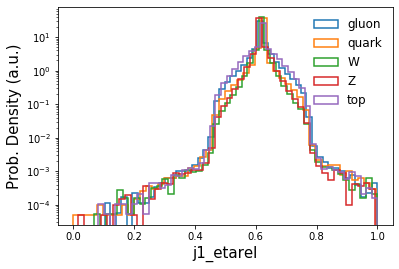

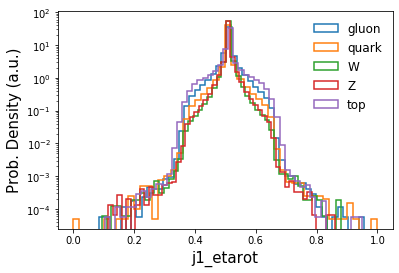

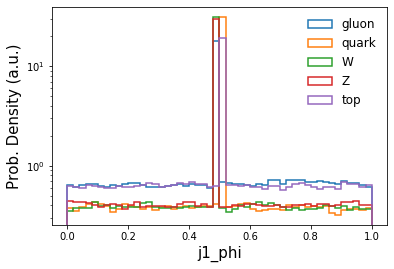

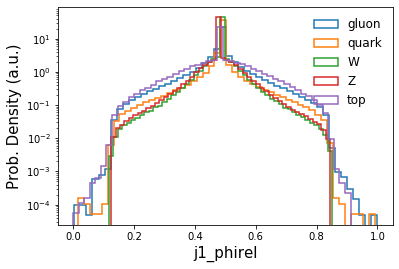

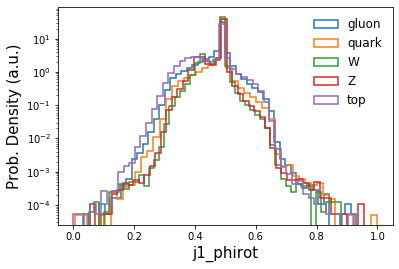

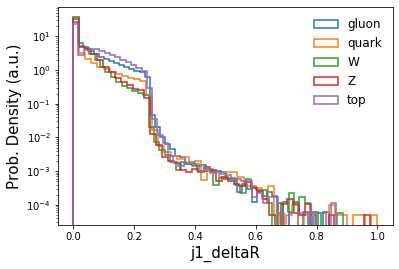

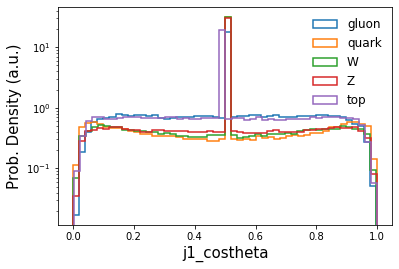

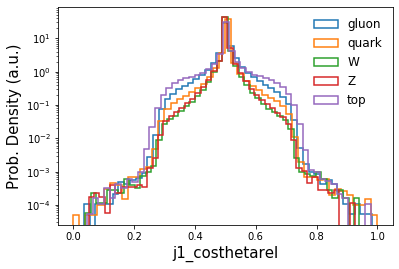

In [35]:
# we now plot all the features
for i in range(len(p_featurenames)-1):
    makePlot_p(jetList[:,:,i], target, p_featurenames[i])
    #fig.show()

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetList, target

(33500, 100, 16) (16500, 100, 16) (33500, 5) (16500, 5)


# Building the RNN model

In [17]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GRU, Dropout, Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [ ]:
####
inputList = Input(shape=(featureArrayLength))
#x = GRU(40, activation="tanh", recurrent_activation='sigmoid')(inputList)
#x = Dropout(dropoutRate)(x)

# xALL, xFinal = GRU(40, return_sequences=True, return_state=True)(inputList)
#x = Dropout(dropoutRate)(xALL)

#x = Conv1D(20, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
#x = AveragePooling1D(pool_size=3)(x)

output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

We now train the model

In [ ]:
batch_size = 128
n_epochs = 200

In [ ]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

In [ ]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()